### Importamos librerias:
* Quitamos alertas de <i>Sklearn.</i>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings, joblib

from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, precision_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings('ignore'
                        , category = ConvergenceWarning
                        , module = 'sklearn')

### Funciones:

In [2]:
def markdown(txt):
    display(Markdown(txt))

In [3]:
def plot(df, col):
    df_temp = df.groupby(col)['Survived']
    df_temp = df_temp.sum() / df_temp.count()
    
    Grafico = df_temp.plot(kind = 'barh'
                       , width = 0.5
                       , color = plt.get_cmap('Blues')(np.linspace(start = 0.15
                                           , stop = 0.85
                                           , num = len(df_temp)))
                       , stacked = True
                       , legend = False
                       , fontsize = 10)
    
    Grafico.set_xlim([0,0.85])
    Grafico.set_ylabel('')
    Grafico.grid(axis='x',alpha=0.25)
    Grafico.set_xticklabels(['{:3.0f} %'.format(x * 100) for x in Grafico.get_xticks()])
    [spine.set_visible(False) for spine in Grafico.spines.values()]
    Grafico.spines['left'].set_visible(True)

    plt.tick_params(left = False, bottom = False)
    plt.title(col)
    df_temp = None

In [4]:
def matriz(y, pred, Modelo = ''):
    mc = confusion_matrix(y, pred)
    Total = sum(np.transpose(mc))
    mcr = np.transpose(np.round(np.transpose(mc) / Total * 100,2))
    MC = pd.DataFrame(mc, columns=['No', 'Si'])

    MC['index'] = ['No', 'Si']
    MC['No'] *= -1

    Grafico = MC.set_index('index').sort_values(['index']
                                                , ascending=False).plot(kind = 'barh'
                                                                        , stacked = True
                                                                        , width = 0.75
                                                                        , color=[['#c9c9c9','#e60000'],['#00c800','#c9c9c9']]
                                                                        , legend = False
                                                                        , figsize = (3,1.2))
    
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    
    plt.gca().grid(axis='x',alpha=0)
    plt.gca().grid(axis='y',alpha=0)
    plt.gca().set_xlabel('{:.2f} % - '.format(np.mean(y == pred) * 100) + Modelo
                         , fontsize = 12
                         , alpha = 0.6)
    plt.gca().set_ylabel('')
    
    [spine.set_visible(False) for spine in plt.gca().spines.values()]
    
    plt.show()

### Importamos datos:
* Eliminamos columnas que contienen información con poco valor predictivo.
* Imputamos valores faltantantes en los campos <b>edad</b> (media del pasaje) y <b>puerto de embarque</b> (asignamos puerto mayoritario).

In [5]:
df = (pd.read_csv('data/train.csv', sep = ',', header = 0)
      .drop(['PassengerId','Name','Cabin'], axis='columns')
      .sample(frac = 1, random_state = 12345))

df.fillna({'Age': df.Age.mean()
           , 'Embarked': df.Embarked.value_counts().index.tolist()[0]}, inplace = True)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
688,0,3,male,18.000000,0,0,350036,7.7958,S
785,0,3,male,25.000000,0,0,374887,7.2500,S
445,1,1,male,4.000000,0,2,33638,81.8583,S
529,0,2,male,23.000000,2,1,29104,11.5000,S
241,1,3,female,29.699118,1,0,367230,15.5000,Q


In [6]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Gráfico de impacto por cada una de las variables:

### Mortalidad en función de cada variable

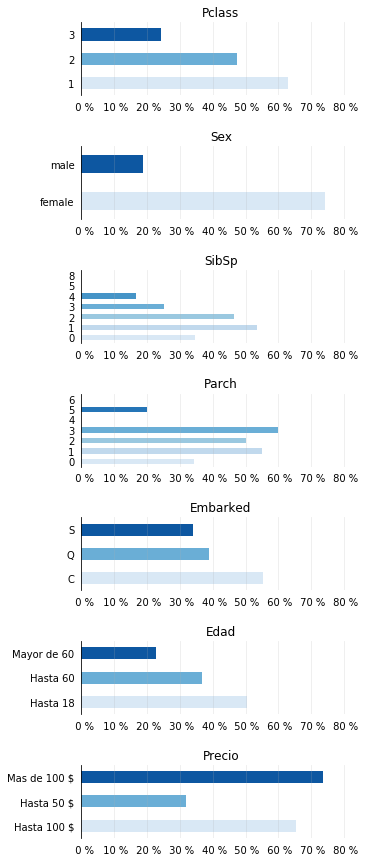

In [7]:
df['Edad'] = df.Age.map(lambda x: 'Hasta 18' if x <= 18 else ('Hasta 60' if x <= 60 else 'Mayor de 60'))
df['Precio'] = df.Fare.map(lambda x: 'Hasta 50 $' if x <= 50 else ('Hasta 100 $' if x <= 100 else 'Mas de 100 $'))

columnsList = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked','Edad', 'Precio']
markdown(f'### Mortalidad en función de cada variable')

Grafico = plt.figure(figsize =(5, 15)) 
Grafico.patch.set_facecolor('white')

plt.subplots_adjust(hspace = .7)

for i in range(1,len(columnsList) + 1):    
    plt.subplot(len(columnsList), 1, i)
    plot(df, columnsList[i -1])

plt.show()
plt.close()

df = df.drop(['Edad','Precio'], axis='columns')

### Dividimos los datos entre Test y Train.

In [8]:
X = df.iloc[:, 1:]
y = df['Survived']

XE, XT, ye, yt = train_test_split(X
                                  , y
                                  , test_size = 0.5
                                  , random_state = 0)

### Configuración de modelos.
* Params con los distintos modelos que entrenamos.
* Configuración PipeLine con la conversión de variables categóricas y StandaeScaler.

In [9]:
Params = {'Random Forest': RandomForestClassifier(n_estimators = 100
                                                   , random_state = 0)
           , 'SGD': SGDClassifier(max_iter=5, tol=None)
           , 'Perceptron': MLPClassifier(random_state = 0)
           , 'KNN': KNeighborsClassifier()
           , 'Tree Classifier': DecisionTreeClassifier(criterion = 'entropy'
                                                       , random_state = 0)
           , 'SVC': SVC(kernel = 'linear'
                        , random_state = 0
                        , gamma = 'scale' )
           , 'Regresión logística': LogisticRegression(solver = 'lbfgs'
                                                       , multi_class = 'multinomial'
                                                       , class_weight = 'balanced'
                                                       , random_state = 0)}

numeric = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'median')), 
        ('scaler', StandardScaler())])

categorical = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'missing')), 
        ('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric, X.select_dtypes(include=['int64', 'float64']).columns), 
        ('cat', categorical, X.select_dtypes(include=['object']).columns)])

### Ejecutamos los modelos y guardamos resultados.
* Mostramos matriz de confusión del mejor resultado.
* Exportamos el modelo .pkl.

### Comparativa de los distintos modelos:

* Matríz de confusión:

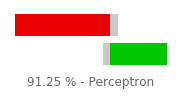

* Ranking Modelos:

,Modelo,Precisión (accuracy),Score (True),R Cuadrado
0,Perceptron,91.25 %,88.82 %,0.63
1,Random Forest,90.68 %,93.02 %,0.61
2,Tree Classifier,89.56 %,88.07 %,0.56
3,SVC,88.78 %,89.54 %,0.53
4,Regresión logística,86.31 %,81.61 %,0.42
5,KNN,81.48 %,79.60 %,0.22
6,SGD,78.45 %,75.34 %,0.09


In [10]:
markdown(f'### Comparativa de los distintos modelos:')
Result = {}

for i in Params:
    Score = []
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Params[i])])
    clf.fit(XE, ye)
    
    Score.append('{:.2f} %'.format(np.mean(y == clf.predict(X)) * 100))
    Score.append('{:.2f} %'.format(precision_score(y, clf.predict(X), labels = [0, 1], pos_label = 1) * 100))
    Score.append('%.2f' % r2_score(y, clf.predict(X)))
    Result[i] = Score
    

Result = (pd.DataFrame(Result, index=['Precisión (accuracy)', 'Score (True)','R Cuadrado'])
          .transpose()
          .sort_values(by = 'Precisión (accuracy)'
                       , ascending = False)
          .reset_index()
          .rename(columns = {'index':'Modelo'})
         )

markdown(f'* Matríz de confusión:')
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Params[Result['Modelo'][0]])])

clf.fit(XE, ye)
joblib.dump(clf, 'models.pkl', compress = 1)
model = joblib.load('models.pkl')

Grafico = matriz(y, model.predict(X), Result['Modelo'][0])        
markdown(f'* Ranking Modelos:')

Result